# What will be the best location to pick-up customers for each day of the week of a month?
As a taxi driver, you always want to know where is the best location to pick up customers. The more customers you get the more profit you earn. In this project, we will use Kmeans Clustering and Polynomial Regression to predict best location for a taxi driver.

## Preamble

In [ ]:
%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import linear_model
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans
from sklearn.metrics import mean_squared_error
from geopy.geocoders import Nominatim
from scipy import cluster
from random import randint
import time

In [ ]:
! pip install -q kaggle

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle (2).json


{'kaggle (2).json': b'{"username":"fizarazvi10","key":"8b8b01fb838f83650c5dc57ed3c48e9d"}'}

In [ ]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [ ]:
! kaggle datasets download elemento/nyc-yellow-taxi-trip-data/data -f yellow_tripdata_2015-01.csv

yellow_tripdata_2015-01.csv.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
import zipfile
zip_ref = zipfile.ZipFile('yellow_tripdata_2015-01.csv.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()

## Load the data
you can get data from this [link](https://s3.amazonaws.com/nyc-tlc/trip+data/yellow_tripdata_2013-01.csv)

## Preprocess data
Since our data is large and exist some ourliers, we have to do preprocess for our data. We need to reduce size of our data and get rid off some ourliers for our data.

In [ ]:
df=pd.read_csv("/content/yellow_tripdata_2015-01.csv")

In [ ]:
df.head()

VendorID tpep_pickup_datetime tpep_dropoff_datetime  passenger_count  \
0         2  2015-01-15 19:05:39   2015-01-15 19:23:42                1   
1         1  2015-01-10 20:33:38   2015-01-10 20:53:28                1   
2         1  2015-01-10 20:33:38   2015-01-10 20:43:41                1   
3         1  2015-01-10 20:33:39   2015-01-10 20:35:31                1   
4         1  2015-01-10 20:33:39   2015-01-10 20:52:58                1   

   trip_distance  pickup_longitude  pickup_latitude  RateCodeID  \
0           1.59        -73.993896        40.750111           1   
1           3.30        -74.001648        40.724243           1   
2           1.80        -73.963341        40.802788           1   
3           0.50        -74.009087        40.713818           1   
4           3.00        -73.971176        40.762428           1   

  store_and_fwd_flag  dropoff_longitude  dropoff_latitude  payment_type  \
0                  N         -73.974785         40.750618             1   
1                  N         -73.994415         40.759109             1   
2                  N         -73.951820         40.824413             2   
3                  N         -74.004326         40.719986             2   
4                  N         -74.004181         40.742653             2   

   fare_amount  extra  mta_tax  tip_amount  tolls_amount  \
0         12.0    1.0      0.5        3.25           0.0   
1         14.5    0.5      0.5        2.00           0.0   
2          9.5    0.5      0.5        0.00           0.0   
3          3.5    0.5      0.5        0.00           0.0   
4         15.0    0.5      0.5        0.00           0.0   

   improvement_surcharge  total_amount  
0                    0.3         17.05  
1                    0.3         17.80  
2                    0.3         10.80  
3                    0.3          4.80  
4                    0.3         16.30

In [ ]:
#create new column call weekday
timestamp = pd.to_datetime(pd.Series(df['tpep_pickup_datetime']))
df['weekday'] = timestamp.dt.day_name()
df.head()

VendorID tpep_pickup_datetime tpep_dropoff_datetime  passenger_count  \
0         2  2015-01-15 19:05:39   2015-01-15 19:23:42                1   
1         1  2015-01-10 20:33:38   2015-01-10 20:53:28                1   
2         1  2015-01-10 20:33:38   2015-01-10 20:43:41                1   
3         1  2015-01-10 20:33:39   2015-01-10 20:35:31                1   
4         1  2015-01-10 20:33:39   2015-01-10 20:52:58                1   

   trip_distance  pickup_longitude  pickup_latitude  RateCodeID  \
0           1.59        -73.993896        40.750111           1   
1           3.30        -74.001648        40.724243           1   
2           1.80        -73.963341        40.802788           1   
3           0.50        -74.009087        40.713818           1   
4           3.00        -73.971176        40.762428           1   

  store_and_fwd_flag  dropoff_longitude  dropoff_latitude  payment_type  \
0                  N         -73.974785         40.750618             1   
1                  N         -73.994415         40.759109             1   
2                  N         -73.951820         40.824413             2   
3                  N         -74.004326         40.719986             2   
4                  N         -74.004181         40.742653             2   

   fare_amount  extra  mta_tax  tip_amount  tolls_amount  \
0         12.0    1.0      0.5        3.25           0.0   
1         14.5    0.5      0.5        2.00           0.0   
2          9.5    0.5      0.5        0.00           0.0   
3          3.5    0.5      0.5        0.00           0.0   
4         15.0    0.5      0.5        0.00           0.0   

   improvement_surcharge  total_amount   weekday  
0                    0.3         17.05  Thursday  
1                    0.3         17.80  Saturday  
2                    0.3         10.80  Saturday  
3                    0.3          4.80  Saturday  
4                    0.3         16.30  Saturday

In [ ]:
#drop unnecessary column
df = df.drop(['VendorID','passenger_count','trip_distance','RateCodeID',
              'store_and_fwd_flag','payment_type','fare_amount','improvement_surcharge','mta_tax',
             'tip_amount','tolls_amount','total_amount','tpep_dropoff_datetime'], axis=1)

#get rid off some garbage data
df=df[(df['pickup_latitude'] > 40.492083) & (df['pickup_latitude']<40.944536) &
     (df['pickup_longitude']> -74.267880)& (df['pickup_longitude']< -73.662022)]

df.head()

tpep_pickup_datetime  pickup_longitude  pickup_latitude  dropoff_longitude  \
0  2015-01-15 19:05:39        -73.993896        40.750111         -73.974785   
1  2015-01-10 20:33:38        -74.001648        40.724243         -73.994415   
2  2015-01-10 20:33:38        -73.963341        40.802788         -73.951820   
3  2015-01-10 20:33:39        -74.009087        40.713818         -74.004326   
4  2015-01-10 20:33:39        -73.971176        40.762428         -74.004181   

   dropoff_latitude  extra   weekday  
0         40.750618    1.0  Thursday  
1         40.759109    0.5  Saturday  
2         40.824413    0.5  Saturday  
3         40.719986    0.5  Saturday  
4         40.742653    0.5  Saturday

## Helper Functions
get functions from "Best Pick-up Location (Q1)"

In [ ]:
#regression function for calculating score
def fit_model_linear_regression(X, y):
    model = Pipeline([('poly', PolynomialFeatures(degree=3)),
                ('linear', LinearRegression(fit_intercept=False))])
    model.fit(X, y)
    return model

def fit_model_random_forest_regression(X, y):
    model = Pipeline([('poly', PolynomialFeatures(degree=3)),
                ('randomforest', RandomForestRegressor())])
    model.fit(X, y)
    return model


def score_model(model, X, y, Xv, yv):
    return tuple([model.score(X, y), model.score(Xv, yv)])

def fit_model_and_score_linear_regression(data, response, validation, val_response):
    model = fit_model_linear_regression(data, response)
    return score_model(model, data, response, validation, val_response)

def fit_model_and_score_random_forest_regression(data, response, validation, val_response):
    model = fit_model_random_forest_regression(data, response)
    return score_model(model, data, response, validation, val_response)



In [ ]:
#convert to address
def convert_to_address(coordinate):
    geolocator = Nominatim()
    location = geolocator.reverse(coordinate)
    return location.address

## Main Function
Combine all the functions from "Best Pick-up Location (Q1)" into one big main function

In [ ]:
df_select=df[(df['weekday']=="Monday") &
                 (pd.to_datetime(df['tpep_pickup_datetime']) < pd.datetime(2015,1+1,1))&
                (pd.to_datetime(df['tpep_pickup_datetime']) > pd.datetime(2015,1,1))]

df_select=df_select[:70000]
#using Kmeans to group data by longitude and latitude
my_cluster=100
lon=df_select['pickup_longitude'].values
lat=df_select['pickup_latitude'].values
coordinate_array=np.array([[lon[i],lat[i]] for i in range(len(lon))])


<ipython-input-66-55c379f07265>:2: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  (pd.to_datetime(df['tpep_pickup_datetime']) < pd.datetime(2015,1+1,1))&
<ipython-input-66-55c379f07265>:3: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  (pd.to_datetime(df['tpep_pickup_datetime']) > pd.datetime(2015,1,1))]


In [ ]:
print("coordinate_array", coordinate_array)

coordinate_array [[-73.96663666  40.80465698]
 [-73.96664429  40.80441666]
 [-73.98281097  40.74525452]
 ...
 [-73.99349213  40.74993134]
 [-73.97612762  40.75602341]
 [-73.99219513  40.7154808 ]]


KeyboardInterrupt: 

Exception ignored in: 'sklearn.cluster._k_means_common._relocate_empty_clusters_dense'
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/numpy/core/multiarray.py", line 346, in where
    @array_function_from_c_func_and_dispatcher(_multiarray_umath.where)
KeyboardInterrupt: 


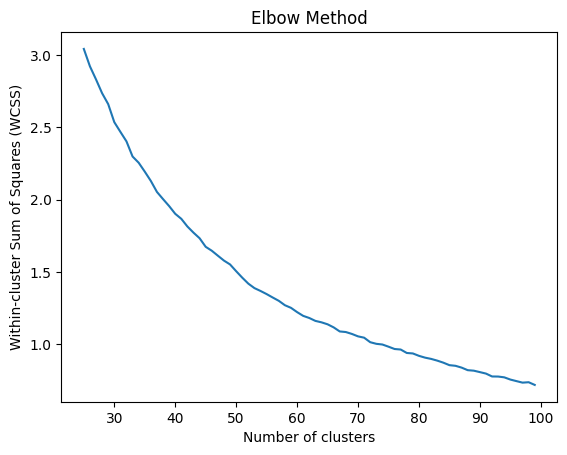

In [ ]:

import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

wcss = []
# Loop through a range of cluster numbers (from 25 to 99)
for i in range(50, 100):
    # Create a KMeans instance with the current number of clusters
    kmeans_n = KMeans(n_clusters=i, n_init=10, random_state=1000)

    # Fit the KMeans model to the data
    kmeans_n.fit(coordinate_array)

    # Calculate the within-cluster sum of squares (inertia) and append it to the list
    wcss.append(kmeans_n.inertia_)

# Plot the elbow curve
plt.plot(range(50, 100), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('Within-cluster Sum of Squares (WCSS)')
plt.show()


In [ ]:
#get best location for each weekday in a month
def poly_linear_regression(my_month,my_weekday,df):
    #get all the selected weekdays in selected month
    df_select=df[(df['weekday']==my_weekday) &
                 (pd.to_datetime(df['tpep_pickup_datetime']) < pd.datetime(2015,my_month+1,1))&
                (pd.to_datetime(df['tpep_pickup_datetime']) > pd.datetime(2015,my_month,1))]

    df_select=df_select[:70000]
    #use Kmean to group data by longitude and latitude
    my_cluster=100
    lon=df_select['pickup_longitude'].values
    lat=df_select['pickup_latitude'].values
    coordinate_array=np.array([[lon[i],lat[i]] for i in range(len(lon))])

    kmeans_n = KMeans(n_clusters=my_cluster,n_init=1,random_state=1000)
    kmeans_n.fit(coordinate_array)
    labels = kmeans_n.labels_

    # add new column call cluster
    df_select['Cluster']=labels

    #prepare for regression
    Cluster_size=df_select.groupby('Cluster').size()
    Cluster_size=np.array([[Cluster_size[i]] for i in range(len(Cluster_size))])
    Cluster_center=kmeans_n.cluster_centers_

    #get training data and testing data
    train_size=int(len(Cluster_size)*0.8)
    test_size=int(len(Cluster_size)*0.2)
    train_feature=Cluster_size[:train_size]
    train_response=Cluster_center[:train_size]
    test_feature=Cluster_size[test_size:]
    test_response=Cluster_center[test_size:]

    #coefficient of determination (R^2)
    print ("Linear Regression: coefficient of determination (R^2):",fit_model_and_score_linear_regression(train_feature, train_response,
                           test_feature, test_response))

    #use mean squared error to evaluation model
    MSE_model=Pipeline([('poly', PolynomialFeatures(degree=3)),
                ('linear', LinearRegression(fit_intercept=False))])
    MSE_model.fit(train_feature, train_response)
    X_MSE=(test_feature)
    y_MSE = MSE_model.predict(X_MSE)
    mse_value = mean_squared_error(test_response, y_MSE)
    print("Linear Regression: MSE: ",mse_value)

    rmse_value = np.sqrt(mse_value)
    print("Linear Regression: RMSE:", rmse_value)

    #predict best location
    X=Cluster_size
    y=Cluster_center

    prediction_model=Pipeline([('poly', PolynomialFeatures(degree=3)),
                    ('linear', LinearRegression(fit_intercept=False))])
    prediction_model.fit(X, y)
    X_predict=([max(Cluster_size)])
    y_predict = prediction_model.predict(X_predict)
    print("Linear Regression: best location for ",my_weekday, y_predict)

    #prepare for visualization
    for data in y_predict:
        visual_x=data[[0]]
        visual_y=data[[1]]

    for i in range(len(Cluster_size)):
        if (Cluster_size[i]==Cluster_size.max()):
            max_size_cluster=i

    actual_value=kmeans_n.cluster_centers_[max_size_cluster]
    actual_x=actual_value[0]
    actual_y=actual_value[1]

    # # convert to address
    # print("address: ",convert_to_address(str(visual_y[0])+","+str(visual_x[0])))

    #visualization for Kmean
    colors = []

    for i in range(my_cluster):
        colors.append('#%06X' % randint(0, 0xFFFFFF))

    plt.figure(figsize=(12,3))
    for i in range(my_cluster):
        my_cluster_df=df_select[df_select['Cluster']==i]
        lon_x=my_cluster_df.pickup_longitude.values
        lat_y=my_cluster_df.pickup_latitude.values
        plt.scatter(lon_x,lat_y,alpha=0.2,s=100,c=colors[i])

    plt.axis([visual_x-0.1,visual_x+0.1,visual_y-0.1,visual_y+0.1])
    plt.title("Linear Regression: visualization for kmean")
    plt.xlabel("longitude")
    plt.ylabel("latitude")
    plt.show()

    #scatter plot all the data for selected weekday and prediction(best location in red)
    fig = plt.figure(figsize=(12,3))
    ax = fig.add_subplot(111)
    x_points=lon
    y_points=lat
    ax.scatter(lon,lat,alpha=0.2,s=100)
    ax.scatter(visual_x,visual_y ,c='r',s=100)
    ax.scatter(actual_x,actual_y ,c='y',s=100)
    ax.axis([visual_x-0.05,visual_x+0.05,visual_y-0.05,visual_y+0.05])
    ax.title.set_text("Linear Regression: Best pick up location (red point=predicted point, yellow point=actual point)")

In [ ]:
#get best location for each weekday in a month
def poly_random_forest_regression(my_month,my_weekday,df):
    #get all the selected weekdays in selected month
    df_select=df[(df['weekday']==my_weekday) &
                 (pd.to_datetime(df['tpep_pickup_datetime']) < pd.datetime(2015,my_month+1,1))&
                (pd.to_datetime(df['tpep_pickup_datetime']) > pd.datetime(2015,my_month,1))]

    df_select=df_select[:70000]
    #use Kmean to group data by longitude and latitude
    my_cluster=100
    lon=df_select['pickup_longitude'].values
    lat=df_select['pickup_latitude'].values
    coordinate_array=np.array([[lon[i],lat[i]] for i in range(len(lon))])

    kmeans_n = KMeans(n_clusters=my_cluster,n_init=1,random_state=1000)
    kmeans_n.fit(coordinate_array)
    labels = kmeans_n.labels_

    # add new column call cluster
    df_select['Cluster']=labels

    #prepare for regression
    Cluster_size=df_select.groupby('Cluster').size()
    Cluster_size=np.array([[Cluster_size[i]] for i in range(len(Cluster_size))])
    Cluster_center=kmeans_n.cluster_centers_

    #get training data and testing data
    train_size=int(len(Cluster_size)*0.8)
    test_size=int(len(Cluster_size)*0.2)
    train_feature=Cluster_size[:train_size]
    train_response=Cluster_center[:train_size]
    test_feature=Cluster_size[test_size:]
    test_response=Cluster_center[test_size:]

    #coefficient of determination (R^2)
    print ("Random Forest Regression: coefficient of determination (R^2):",fit_model_and_score_random_forest_regression(train_feature, train_response,
                           test_feature, test_response))

    #use mean squared error to evaluation model
    MSE_model=Pipeline([('poly', PolynomialFeatures(degree=3)),
                ('randomforest', RandomForestRegressor())])
    MSE_model.fit(train_feature, train_response)
    X_MSE=(test_feature)
    y_MSE = MSE_model.predict(X_MSE)
    mse_value = mean_squared_error(test_response, y_MSE)
    print("Random Forest Regression: MSE: ",mse_value)

    rmse_value = np.sqrt(mse_value)
    print("Random Forest Regression: RMSE:", rmse_value)

    #predict best location
    X=Cluster_size
    y=Cluster_center

    prediction_model=Pipeline([('poly', PolynomialFeatures(degree=3)),
                    ('randomforest', RandomForestRegressor())])
    prediction_model.fit(X, y)
    X_predict=([max(Cluster_size)])
    y_predict = prediction_model.predict(X_predict)
    print("Random Forest Regression: best location for ",my_weekday, y_predict)

    #prepare for visualization
    for data in y_predict:
        visual_x=data[[0]]
        visual_y=data[[1]]

    for i in range(len(Cluster_size)):
        if (Cluster_size[i]==Cluster_size.max()):
            max_size_cluster=i

    actual_value=kmeans_n.cluster_centers_[max_size_cluster]
    actual_x=actual_value[0]
    actual_y=actual_value[1]

    # # convert to address
    # print("address: ",convert_to_address(str(visual_y[0])+","+str(visual_x[0])))

    #visualization for Kmean
    colors = []

    for i in range(my_cluster):
        colors.append('#%06X' % randint(0, 0xFFFFFF))

    plt.figure(figsize=(12,3))
    for i in range(my_cluster):
        my_cluster_df=df_select[df_select['Cluster']==i]
        lon_x=my_cluster_df.pickup_longitude.values
        lat_y=my_cluster_df.pickup_latitude.values
        plt.scatter(lon_x,lat_y,alpha=0.2,s=100,c=colors[i])

    plt.axis([visual_x-0.1,visual_x+0.1,visual_y-0.1,visual_y+0.1])
    plt.title("visualization for kmean")
    plt.xlabel("longitude")
    plt.ylabel("latitude")
    plt.show()

    #scatter plot all the data for selected weekday and prediction(best location in red)
    fig = plt.figure(figsize=(12,3))
    ax = fig.add_subplot(111)
    x_points=lon
    y_points=lat
    ax.scatter(lon,lat,alpha=0.2,s=100)
    ax.scatter(visual_x,visual_y ,c='r',s=100)
    ax.scatter(actual_x,actual_y ,c='y',s=100)
    ax.axis([visual_x-0.05,visual_x+0.05,visual_y-0.05,visual_y+0.05])
    ax.title.set_text("Random Forest Regression: Best pick up location (red point=predicted point, yellow point=actual point)")

## Execution
Execute main function to get prediction, validation values, location, visualization for each day of the week in a month

<ipython-input-77-39d77b6cce69>:5: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  (pd.to_datetime(df['tpep_pickup_datetime']) < pd.datetime(2015,my_month+1,1))&
<ipython-input-77-39d77b6cce69>:6: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  (pd.to_datetime(df['tpep_pickup_datetime']) > pd.datetime(2015,my_month,1))]


Linear Regression: coefficient of determination (R^2): (0.08614748784612625, -0.007408454150242716)
Linear Regression: MSE:  0.004098252356164222
Linear Regression: RMSE: 0.06401759411415132
Linear Regression: best location for  Monday [[-73.9720905   40.75688403]]


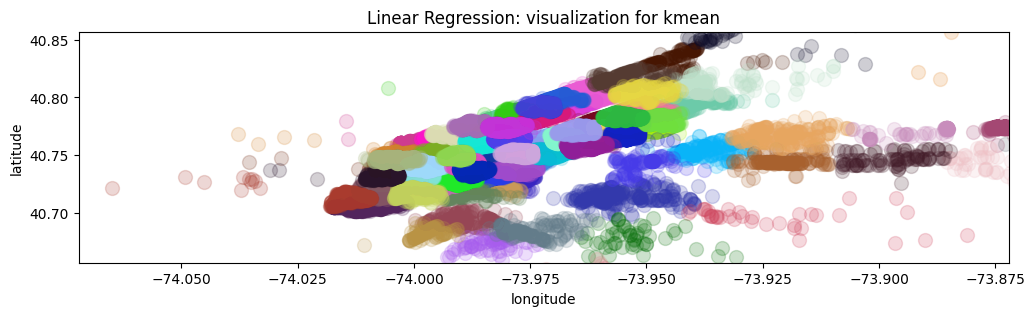

None


<ipython-input-80-33245a0ad0bb>:5: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  (pd.to_datetime(df['tpep_pickup_datetime']) < pd.datetime(2015,my_month+1,1))&
<ipython-input-80-33245a0ad0bb>:6: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  (pd.to_datetime(df['tpep_pickup_datetime']) > pd.datetime(2015,my_month,1))]


Random Forest Regression: coefficient of determination (R^2): (0.5766213839508341, 0.2818514699255902)
Random Forest Regression: MSE:  0.0031211453343736846
Random Forest Regression: RMSE: 0.05586721162160937
Random Forest Regression: best location for  Monday [[-73.98213495  40.75354347]]


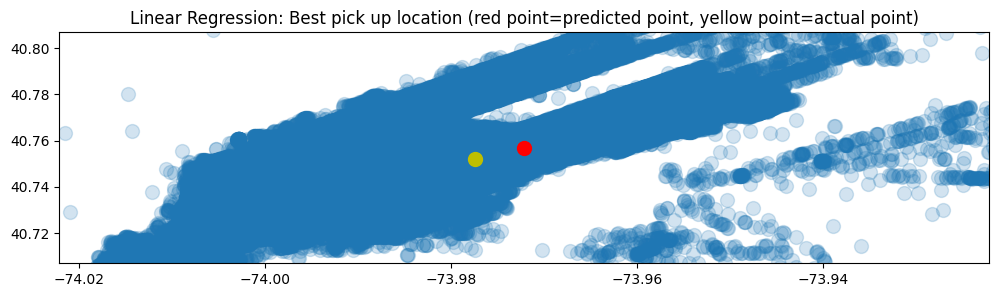

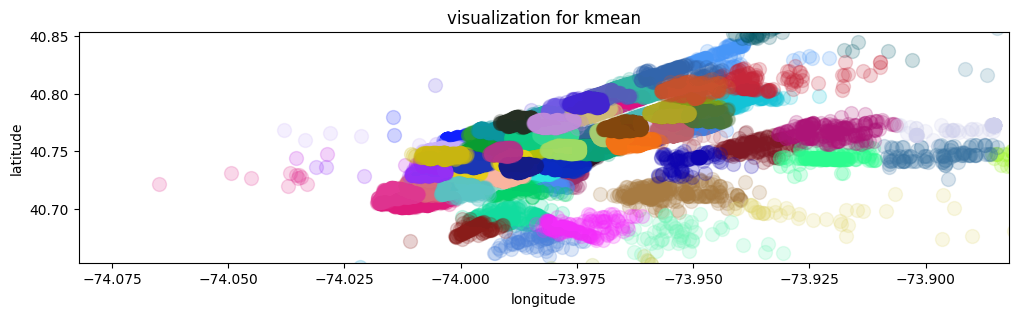

None


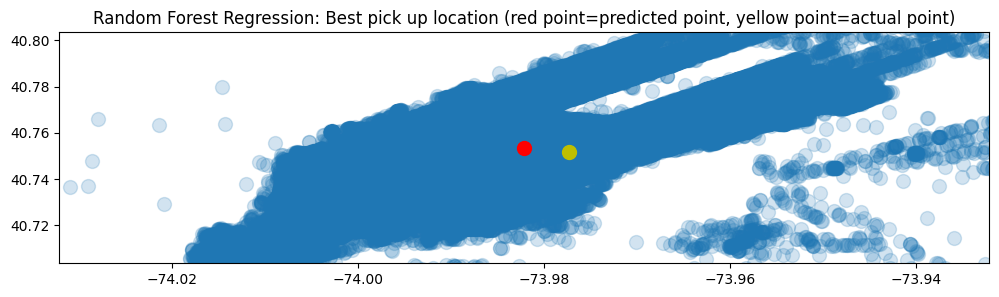

In [ ]:
dayweek = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
print(poly_linear_regression(1,dayweek[0],df))
print(poly_random_forest_regression(1,dayweek[0],df))

<ipython-input-77-39d77b6cce69>:5: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  (pd.to_datetime(df['tpep_pickup_datetime']) < pd.datetime(2015,my_month+1,1))&
<ipython-input-77-39d77b6cce69>:6: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  (pd.to_datetime(df['tpep_pickup_datetime']) > pd.datetime(2015,my_month,1))]


Linear Regression: coefficient of determination (R^2): (0.0294047927982104, 0.05374810172702177)
Linear Regression: MSE:  0.0033696512504710484
Linear Regression: RMSE: 0.0580486972331942
Linear Regression: best location for  Tuesday [[-73.97809205  40.74386207]]


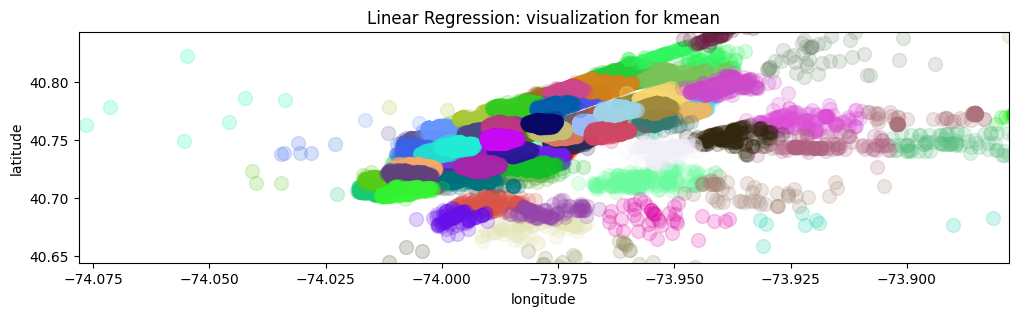

None


<ipython-input-80-33245a0ad0bb>:5: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  (pd.to_datetime(df['tpep_pickup_datetime']) < pd.datetime(2015,my_month+1,1))&
<ipython-input-80-33245a0ad0bb>:6: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  (pd.to_datetime(df['tpep_pickup_datetime']) > pd.datetime(2015,my_month,1))]


Random Forest Regression: coefficient of determination (R^2): (0.670211407384462, 0.19123951731153244)
Random Forest Regression: MSE:  0.0028615325176856252
Random Forest Regression: RMSE: 0.05349329413754237
Random Forest Regression: best location for  Tuesday [[-73.98809799  40.75099992]]


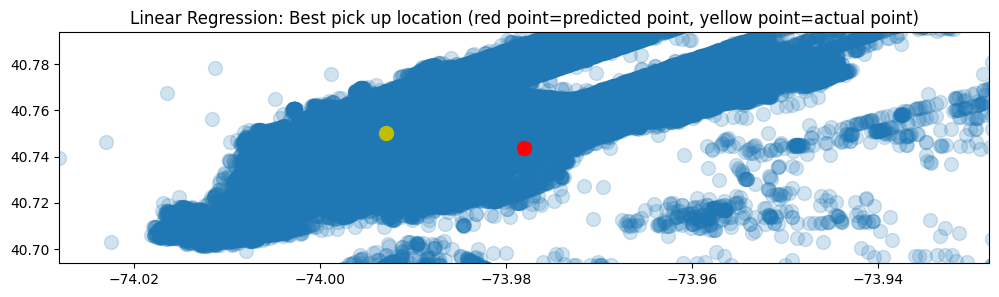

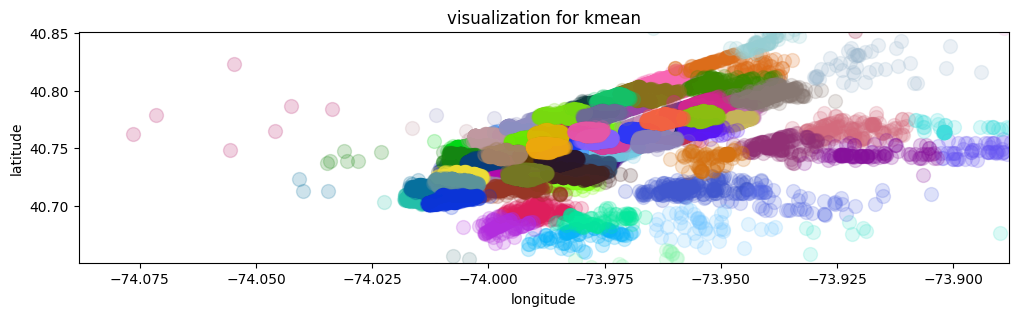

None


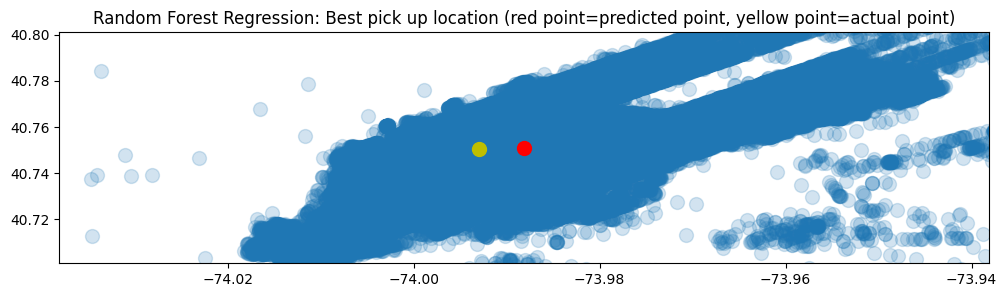

In [ ]:
print(poly_linear_regression(1,dayweek[1],df))
print(poly_random_forest_regression(1,dayweek[1],df))

<ipython-input-77-39d77b6cce69>:5: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  (pd.to_datetime(df['tpep_pickup_datetime']) < pd.datetime(2015,my_month+1,1))&
<ipython-input-77-39d77b6cce69>:6: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  (pd.to_datetime(df['tpep_pickup_datetime']) > pd.datetime(2015,my_month,1))]


Linear Regression: coefficient of determination (R^2): (0.03919927932475048, 0.08515014825001432)
Linear Regression: MSE:  0.0034138785329126935
Linear Regression: RMSE: 0.05842840518885222
Linear Regression: best location for  Wednesday [[-74.01171975  40.76747477]]


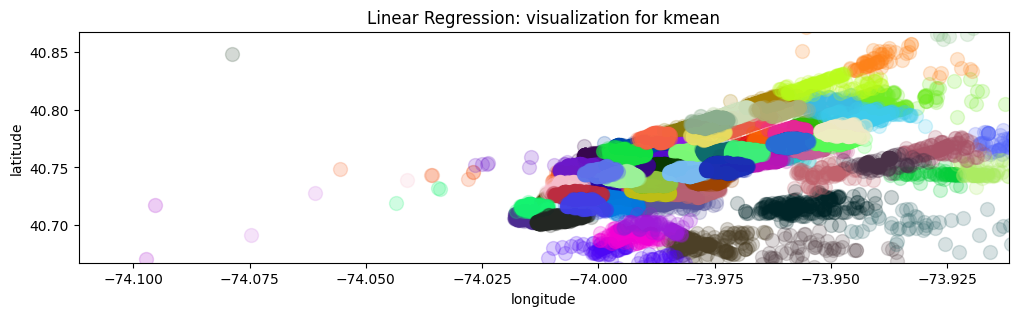

None


<ipython-input-80-33245a0ad0bb>:5: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  (pd.to_datetime(df['tpep_pickup_datetime']) < pd.datetime(2015,my_month+1,1))&
<ipython-input-80-33245a0ad0bb>:6: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  (pd.to_datetime(df['tpep_pickup_datetime']) > pd.datetime(2015,my_month,1))]


Random Forest Regression: coefficient of determination (R^2): (0.7297354819712808, 0.6501188933576623)
Random Forest Regression: MSE:  0.0012916946185740396
Random Forest Regression: RMSE: 0.035940153290909035
Random Forest Regression: best location for  Wednesday [[-73.98360179  40.75424486]]


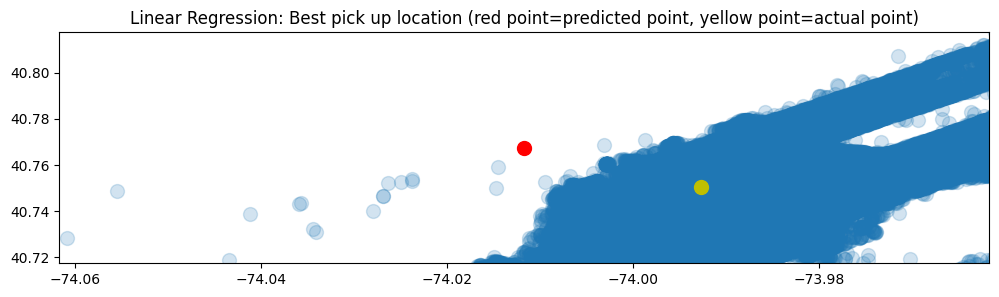

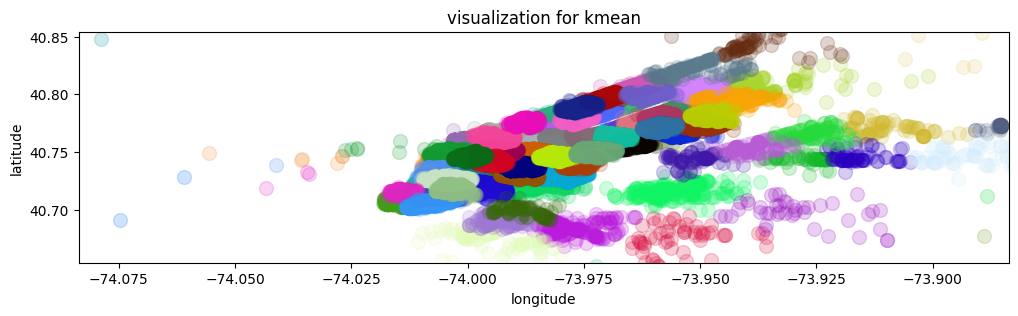

None


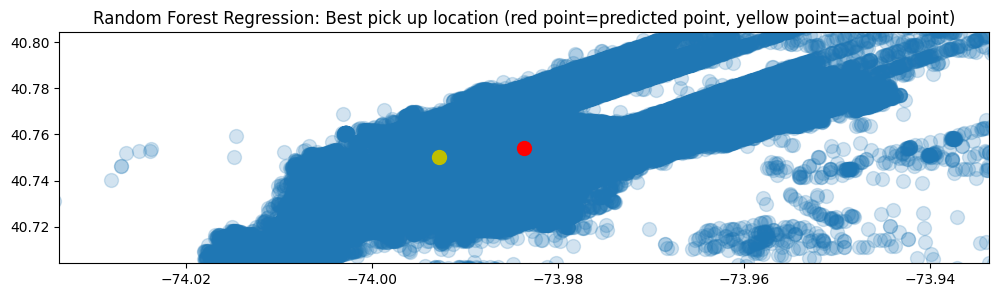

In [ ]:
print(poly_linear_regression(1,dayweek[2],df))
print(poly_random_forest_regression(1,dayweek[2],df))

<ipython-input-77-39d77b6cce69>:5: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  (pd.to_datetime(df['tpep_pickup_datetime']) < pd.datetime(2015,my_month+1,1))&
<ipython-input-77-39d77b6cce69>:6: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  (pd.to_datetime(df['tpep_pickup_datetime']) > pd.datetime(2015,my_month,1))]


Linear Regression: coefficient of determination (R^2): (0.08875461771914128, 0.12329022886107849)
Linear Regression: MSE:  0.0028336499410204783
Linear Regression: RMSE: 0.05323203867052696
Linear Regression: best location for  Thursday [[-73.99448111  40.7652907 ]]


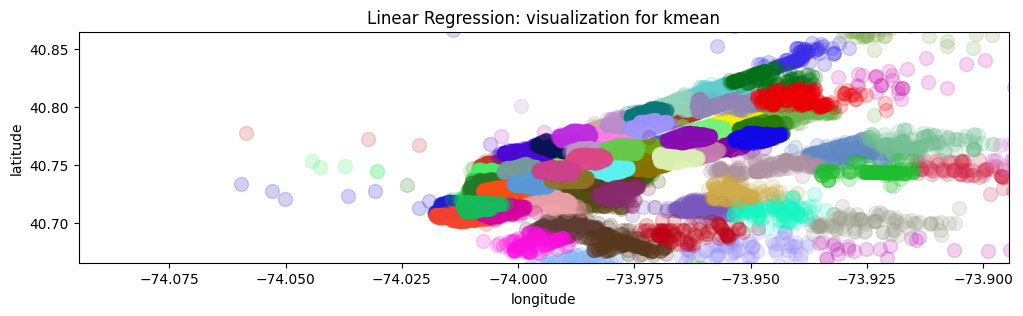

None


<ipython-input-80-33245a0ad0bb>:5: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  (pd.to_datetime(df['tpep_pickup_datetime']) < pd.datetime(2015,my_month+1,1))&
<ipython-input-80-33245a0ad0bb>:6: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  (pd.to_datetime(df['tpep_pickup_datetime']) > pd.datetime(2015,my_month,1))]


Random Forest Regression: coefficient of determination (R^2): (0.7214867681939753, 0.46075234054405)
Random Forest Regression: MSE:  0.0017272639539233328
Random Forest Regression: RMSE: 0.04156036518034139
Random Forest Regression: best location for  Thursday [[-73.98586517  40.75389513]]


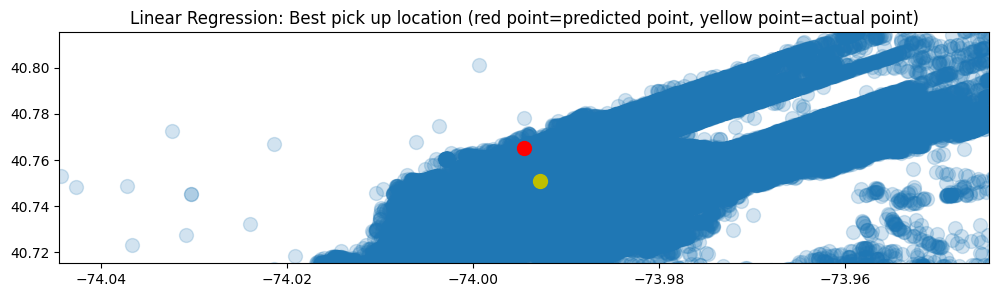

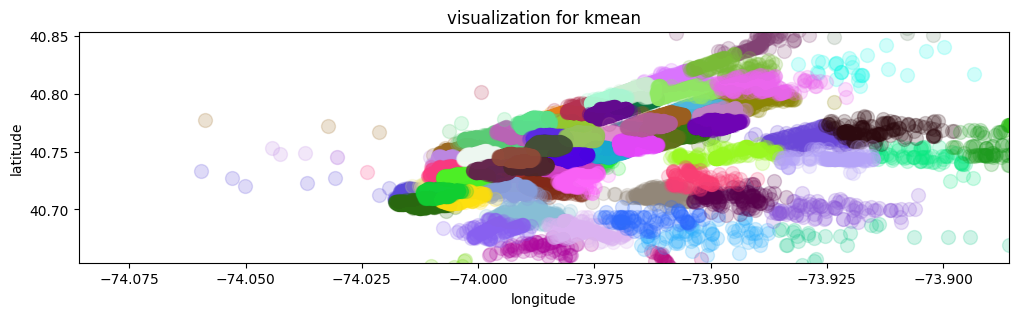

None


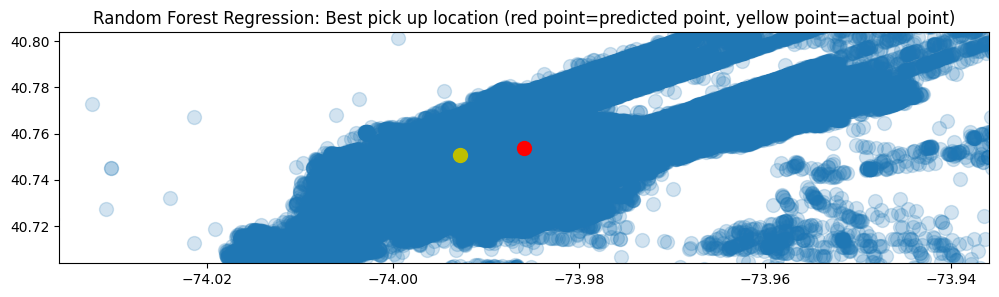

In [ ]:
print(poly_linear_regression(1,dayweek[3],df))
print(poly_random_forest_regression(1,dayweek[3],df))

<ipython-input-77-39d77b6cce69>:5: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  (pd.to_datetime(df['tpep_pickup_datetime']) < pd.datetime(2015,my_month+1,1))&
<ipython-input-77-39d77b6cce69>:6: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  (pd.to_datetime(df['tpep_pickup_datetime']) > pd.datetime(2015,my_month,1))]


Linear Regression: coefficient of determination (R^2): (0.027015313656752193, 0.0038785798592875786)
Linear Regression: MSE:  0.004038448766926606
Linear Regression: RMSE: 0.06354879044424533
Linear Regression: best location for  Friday [[-73.98981487  40.74945489]]


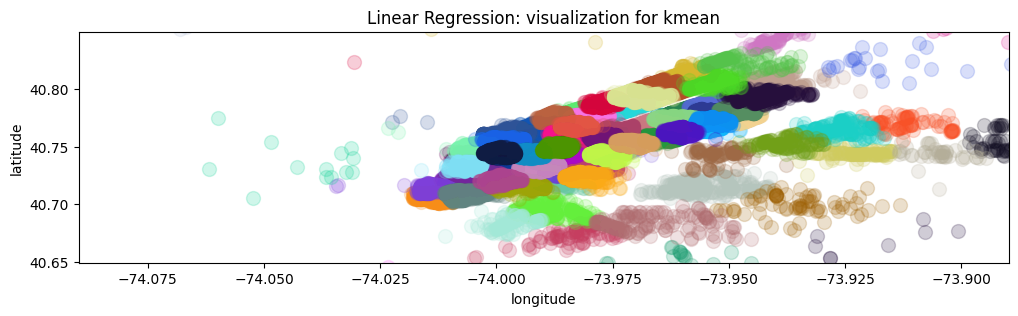

None


<ipython-input-80-33245a0ad0bb>:5: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  (pd.to_datetime(df['tpep_pickup_datetime']) < pd.datetime(2015,my_month+1,1))&
<ipython-input-80-33245a0ad0bb>:6: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  (pd.to_datetime(df['tpep_pickup_datetime']) > pd.datetime(2015,my_month,1))]


Random Forest Regression: coefficient of determination (R^2): (0.6558757358164007, 0.32808075601660647)
Random Forest Regression: MSE:  0.0028895901814294457
Random Forest Regression: RMSE: 0.05375490844034102
Random Forest Regression: best location for  Friday [[-73.9919879   40.75234222]]


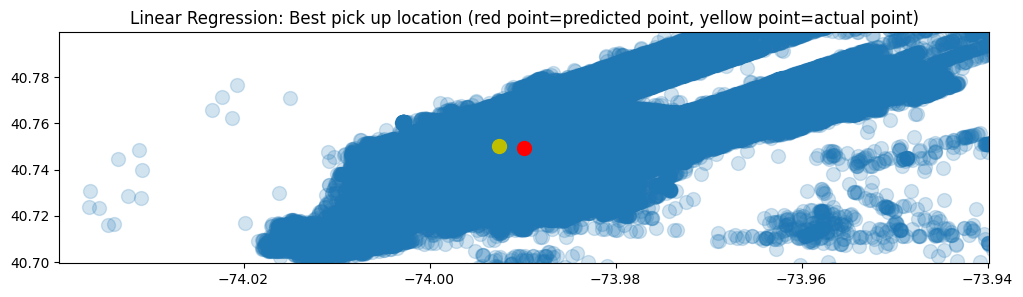

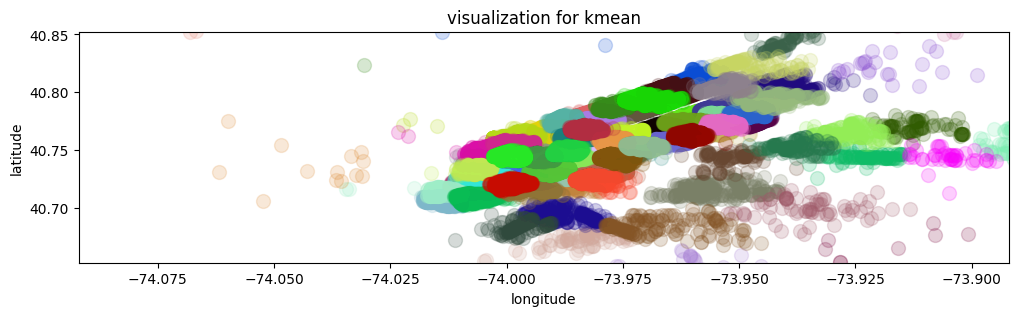

None


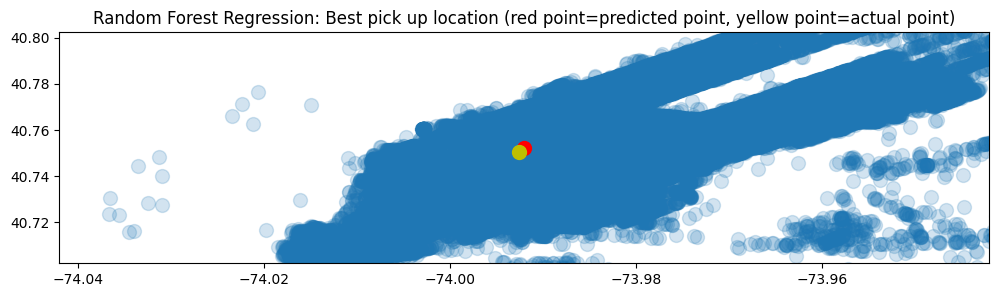

In [ ]:
print(poly_linear_regression(1,dayweek[4],df))
print(poly_random_forest_regression(1,dayweek[4],df))

<ipython-input-77-39d77b6cce69>:5: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  (pd.to_datetime(df['tpep_pickup_datetime']) < pd.datetime(2015,my_month+1,1))&
<ipython-input-77-39d77b6cce69>:6: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  (pd.to_datetime(df['tpep_pickup_datetime']) > pd.datetime(2015,my_month,1))]


Linear Regression: coefficient of determination (R^2): (0.029137237224502954, 0.026015255270268323)
Linear Regression: MSE:  0.0033472898302649287
Linear Regression: RMSE: 0.05785576747624154
Linear Regression: best location for  Saturday [[-73.96382139  40.75442815]]


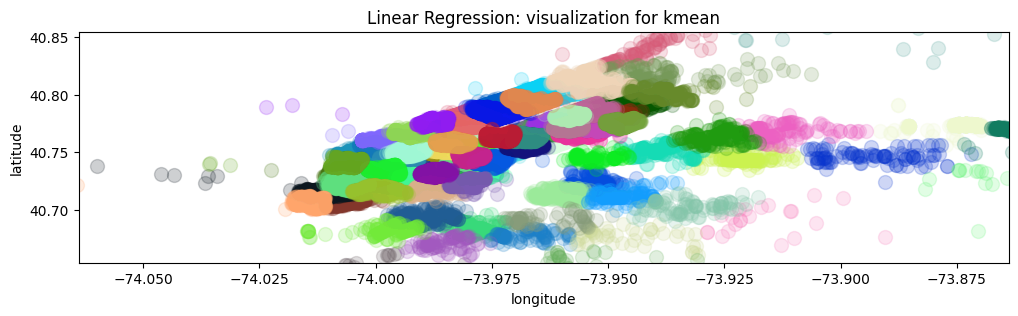

None


<ipython-input-80-33245a0ad0bb>:5: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  (pd.to_datetime(df['tpep_pickup_datetime']) < pd.datetime(2015,my_month+1,1))&
<ipython-input-80-33245a0ad0bb>:6: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  (pd.to_datetime(df['tpep_pickup_datetime']) > pd.datetime(2015,my_month,1))]


Random Forest Regression: coefficient of determination (R^2): (0.7810542207849592, 0.37909429569414294)
Random Forest Regression: MSE:  0.0018269705927094048
Random Forest Regression: RMSE: 0.042743076547078415
Random Forest Regression: best location for  Saturday [[-73.99284316  40.74659426]]


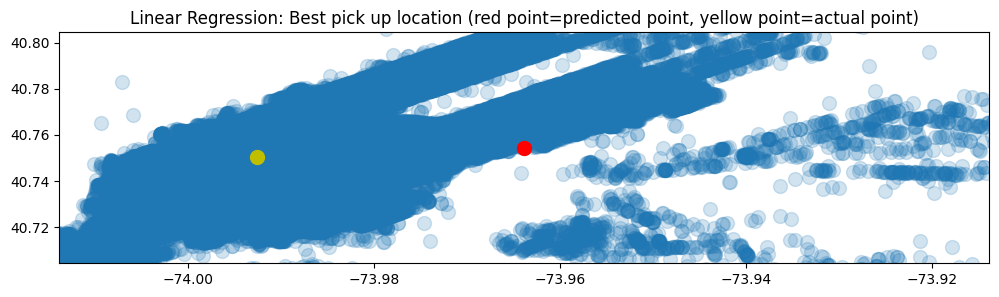

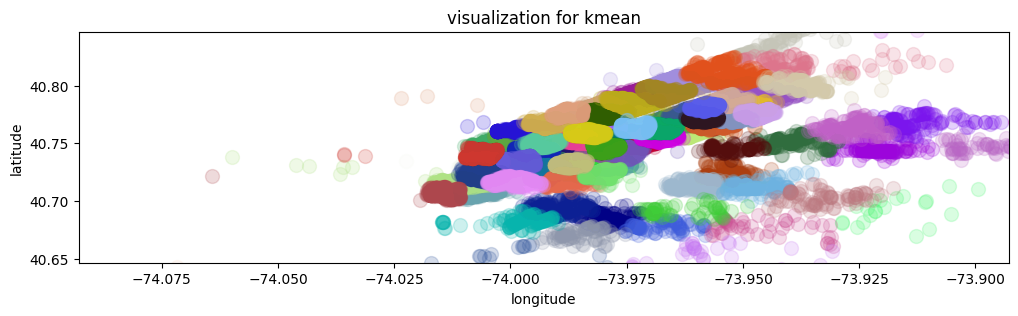

None


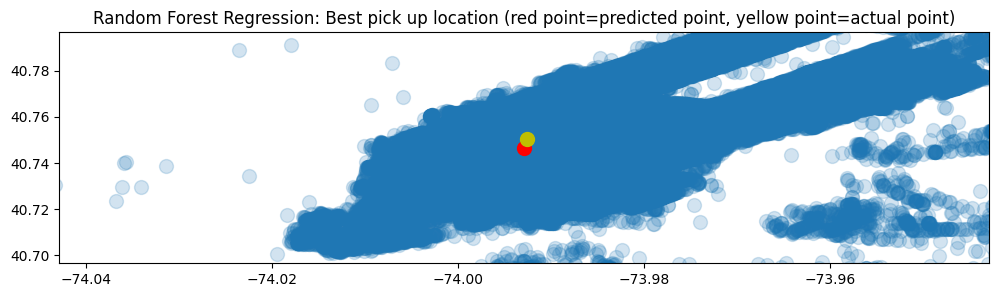

In [ ]:
print(poly_linear_regression(1,dayweek[5],df))
print(poly_random_forest_regression(1,dayweek[5],df))

<ipython-input-77-39d77b6cce69>:5: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  (pd.to_datetime(df['tpep_pickup_datetime']) < pd.datetime(2015,my_month+1,1))&
<ipython-input-77-39d77b6cce69>:6: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  (pd.to_datetime(df['tpep_pickup_datetime']) > pd.datetime(2015,my_month,1))]


Linear Regression: coefficient of determination (R^2): (0.029371482198633447, 0.027705181863560746)
Linear Regression: MSE:  0.0030471711391766784
Linear Regression: RMSE: 0.0552011878420807
Linear Regression: best location for  Sunday [[-73.99420766  40.74896104]]


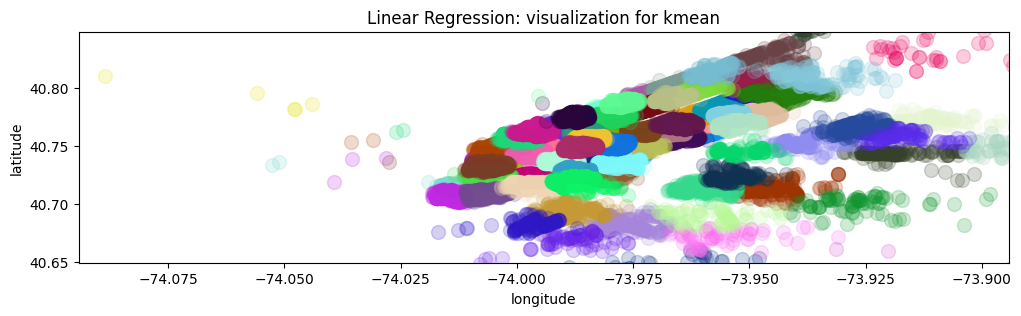

None


<ipython-input-80-33245a0ad0bb>:5: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  (pd.to_datetime(df['tpep_pickup_datetime']) < pd.datetime(2015,my_month+1,1))&
<ipython-input-80-33245a0ad0bb>:6: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  (pd.to_datetime(df['tpep_pickup_datetime']) > pd.datetime(2015,my_month,1))]


Random Forest Regression: coefficient of determination (R^2): (0.7413835504711883, 0.2922278431290124)
Random Forest Regression: MSE:  0.002341235055981209
Random Forest Regression: RMSE: 0.04838631062584963
Random Forest Regression: best location for  Sunday [[-73.99183858  40.74220713]]


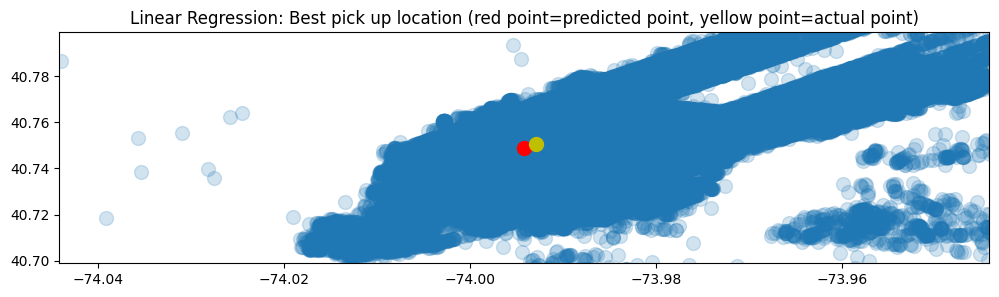

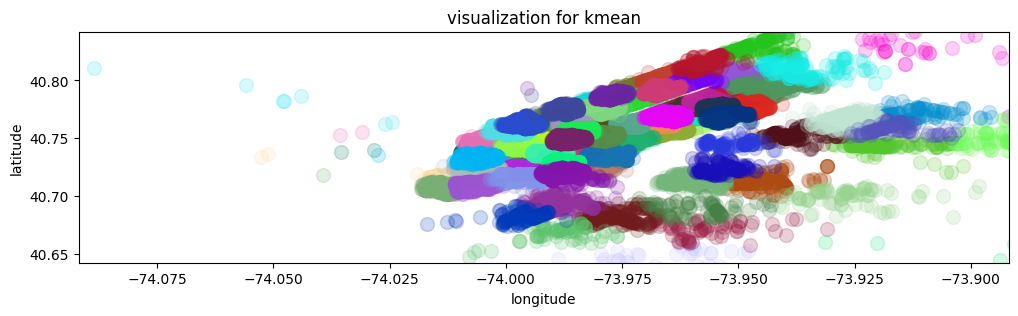

None


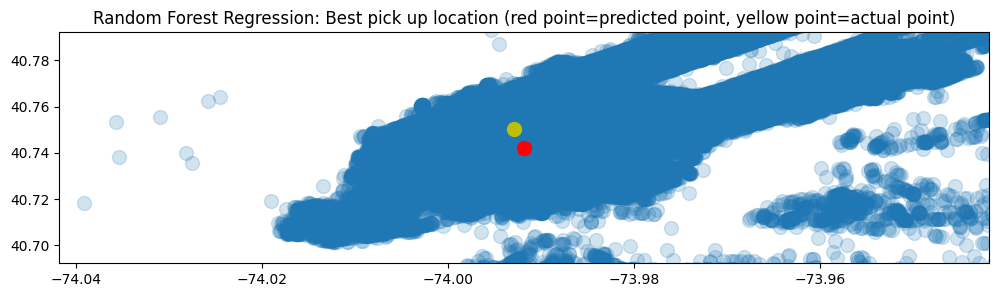

In [ ]:
print(poly_linear_regression(1,dayweek[6],df))
print(poly_random_forest_regression(1,dayweek[6],df))